# In this file we start with creating MEP networks for GEPHI visualizations and then we run frustration analysis

In [6]:
# Dual-dataset MEP and Party Network Analysis
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform



In [7]:
# Data loading and dummy-coding helpers

def build_dummy_dataframe(all_votes_path: str) -> pd.DataFrame:
    df0_local = pd.read_csv(all_votes_path, sep=',')
    vote_cols = [c for c in df0_local.columns if c.isdigit()]
    meta_cols = [
        "member.id",
        "member.first_name",
        "member.last_name",
        "member.country.code",
        "member.country.label",
        "member.group.code",
        "member.group.label",
        "member.group.short_label",
    ]
    meta_cols = [c for c in meta_cols if c in df0_local.columns]

    df_meta_local = df0_local[meta_cols].copy()
    df_nodes_local = df0_local[vote_cols].copy()

    df_dummy_local = pd.get_dummies(df_nodes_local, prefix_sep=":").astype(bool)
    df_final_local = pd.concat([df_meta_local, df_dummy_local], axis=1)
    return df_final_local


In [8]:
# MEP similarity network creation

def create_mep_similarity_network(df_final, similarity_threshold=0.5):
    meta_cols = [c for c in df_final.columns if c.startswith('member.')]
    vote_cols = [c for c in df_final.columns if ':' in c]

    df_meta = df_final[meta_cols].copy()
    df_votes = df_final[vote_cols].copy()

    df_meta['mep_id'] = df_meta['member.id'].astype(str)
    df_votes.index = df_meta['mep_id']

    mep_votes = df_votes.astype(int)

    similarity_matrix = cosine_similarity(mep_votes)

    G_mep = nx.Graph()
    for i, mep_id in enumerate(mep_votes.index):
        G_mep.add_node(mep_id)
        mep_info = df_meta.iloc[i]
        #G_mep.nodes[mep_id]['name'] = f"{mep_info['member.first_name']} {mep_info['member.last_name']}"
        #G_mep.nodes[mep_id]['country'] = mep_info['member.country.label']
        G_mep.nodes[mep_id]['party'] = mep_info['member.group.short_label']
        #G_mep.nodes[mep_id]['party_full'] = mep_info['member.group.label']

    n_meps = len(mep_votes.index)
    for i in range(n_meps):
        for j in range(i+1, n_meps):
            similarity = similarity_matrix[i, j]
            if similarity >= similarity_threshold:
                mep1 = mep_votes.index[i]
                mep2 = mep_votes.index[j]
                G_mep.add_edge(mep1, mep2, weight=similarity)

    return G_mep, mep_votes, df_meta


In [9]:
# MEP visualization, analysis, and silhouette

def visualize_mep_network(G_mep, party_colors, layout='spring', figsize=(15, 12)):
    node_colors = []
    for node in G_mep.nodes():
        party = G_mep.nodes[node].get('party')
        node_colors.append(party_colors.get(party, '#cccccc'))

    if layout == 'spring':
        pos = nx.spring_layout(G_mep, k=3, iterations=50)
    elif layout == 'circular':
        pos = nx.circular_layout(G_mep)
    else:
        pos = nx.spring_layout(G_mep)

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G_mep, pos, alpha=0.3, width=0.5, edge_color='gray')
    nx.draw_networkx_nodes(G_mep, pos, node_color=node_colors, node_size=60, alpha=0.8)
    plt.title(f"MEP Similarity Network (n={G_mep.number_of_nodes()}, e={G_mep.number_of_edges()})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return pos


def analyze_mep_network(G_mep):
    degrees = [G_mep.degree(node) for node in G_mep.nodes()]
    print(f"Nodes: {G_mep.number_of_nodes()} | Edges: {G_mep.number_of_edges()} | Density: {nx.density(G_mep):.4f}")
    if degrees:
        print(f"Avg degree: {np.mean(degrees):.2f} | Max: {np.max(degrees)} | Min: {np.min(degrees)}")


# def party_color_map():
#     return {
#         'EPP': '#1f77b4', 'S&D': '#ff7f0e', 'Renew': '#2ca02c', 'Greens/EFA': '#00ff00',
#         'ECR': '#d62728', 'ID': '#8c564b', 'GUE/NGL': '#e377c2', 'PFE': '#7f7f7f',
#         'ESN': '#bcbd22', 'NI': '#17becf', 'The Left': '#e377c2', 'Non-attached': '#17becf'
#     }


def silhouette_mep_votes(mep_votes, mep_meta):
    X = mep_votes.values.astype(int)
    party_labels = mep_meta['member.group.short_label'].astype(str).values
    D = pairwise_distances(X, metric='cosine')
    np.fill_diagonal(D, 0.0)
    sil_party = silhouette_score(D, party_labels, metric='precomputed')
    k = len(np.unique(party_labels))
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    sil_cluster = silhouette_score(X, km.labels_, metric='cosine')
    return sil_party, sil_cluster


def save_mep_gexf(G_mep, dataset_name: str):
    filename_mep = f'EP_MEP_{dataset_name}.gexf'
    nx.write_gexf(G_mep, filename_mep)
    print(f"Saved {filename_mep}")


In [17]:
def create_single_party_network(df_final, party_code):
    """Builds an internal-party network where edge distance reflects disagreement."""
    
    party_col = "member.group.short_label"
    if party_col not in df_final.columns:
        raise ValueError("Party column not found.")

    df_party = df_final[df_final[party_col] == party_code].copy()
    if df_party.shape[0] < 3:
        return None, None, None  # too few MEPs

    vote_cols = [c for c in df_party.columns if ":" in c]
    votes = df_party[vote_cols].astype(int)
    votes.index = df_party["member.id"].astype(str)

    # Similarity (agreement)
    similarity = cosine_similarity(votes)

    # Convert to disagreement distance
    distance = 1 - similarity  # ∈ [0,2]
    
    # Build graph
    G = nx.Graph()
    meps = votes.index.tolist()

    for mep in meps:
        G.add_node(mep, party=party_code)

    n = len(meps)
    for i in range(n):
        for j in range(i+1, n):
            d = float(distance[i, j])
            s = float(similarity[i, j])
            G.add_edge(
                meps[i], meps[j],
                weight=d,               # disagreement distance
                similarity=s,
                distance=d
            )

    return G, votes, df_party

In [18]:
# Party similarity network functions

def create_party_similarity_network(df_final, similarity_threshold=0.3):
    meta_cols = [c for c in df_final.columns if c.startswith('member.')]
    vote_cols = [c for c in df_final.columns if ':' in c]

    df_meta = df_final[meta_cols].copy()
    df_votes = df_final[vote_cols].copy().astype(int)

    party_votes = df_votes.groupby(df_meta['member.group.short_label']).mean()

    similarity_matrix = cosine_similarity(party_votes)

    G_party = nx.Graph()
    for i, party_name in enumerate(party_votes.index):
        G_party.add_node(party_name)
        party_meps = df_meta[df_meta['member.group.short_label'] == party_name]
        G_party.nodes[party_name]['mep_count'] = len(party_meps)
        G_party.nodes[party_name]['countries'] = list(party_meps['member.country.label'].unique())

    n_parties = len(party_votes.index)
    for i in range(n_parties):
        for j in range(i+1, n_parties):
            sim = similarity_matrix[i, j]
            if sim >= similarity_threshold:
                p1 = party_votes.index[i]
                p2 = party_votes.index[j]
                G_party.add_edge(p1, p2, weight=sim)

    return G_party, party_votes, df_meta


def visualize_party_network(G_party, party_colors, layout='spring', figsize=(12, 10)):
    node_colors = [party_colors.get(node, '#cccccc') for node in G_party.nodes()]
    node_sizes = [200 + G_party.nodes[node].get('mep_count', 0) * 10 for node in G_party.nodes()]

    if layout == 'spring':
        pos = nx.spring_layout(G_party, k=5, iterations=100)
    elif layout == 'circular':
        pos = nx.circular_layout(G_party)
    else:
        pos = nx.spring_layout(G_party)

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G_party, pos, alpha=0.6, width=2, edge_color='gray')
    nx.draw_networkx_nodes(G_party, pos, node_color=node_colors, node_size=node_sizes, alpha=0.85)
    nx.draw_networkx_labels(G_party, pos, font_size=9, font_weight='bold')
    plt.title(f"Party Similarity Network (n={G_party.number_of_nodes()}, e={G_party.number_of_edges()})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return pos


def save_party_gexf(G_party, dataset_name: str):
    G_party_clean = G_party.copy()
    for node in G_party_clean.nodes():
        if 'countries' in G_party_clean.nodes[node]:
            G_party_clean.nodes[node]['countries'] = ', '.join(G_party_clean.nodes[node]['countries'])
    filename_party = f'EP_parties_similarity_{dataset_name}.gexf'
    nx.write_gexf(G_party_clean, filename_party)
    print(f"Saved {filename_party}")


In [22]:
def layout_disagreement(G):
    # NetworkX spring_layout: large weights → short edges.
    # We want: large distance → long edges.
    # → So use: weight = 1 / (distance + 1e-6)

    spring_weights = {}

    for u, v, data in G.edges(data=True):
        d = data["distance"]
        spring_weights[(u, v)] = 1.0 / (d + 1e-6)

    pos = nx.spring_layout(G, weight=spring_weights, k=1, iterations=200)
    return pos

def visualize_party_internal(G, party_name):
    pos = layout_disagreement(G)

    weights = [data["distance"] for _, _, data in G.edges(data=True)]

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.coolwarm,
                           width=1.5, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_color="black", node_size=40)

    plt.title(f"Internal disagreement network: {party_name}")
    plt.axis("off")
    plt.show()

In [ ]:
# PER PARTY NETWORK

DATASETS = [
    # ("EP6_main", "data/all_votes_main_EP6.csv"),
    # ("EP7_main", "data/all_votes_main_EP7.csv"),
    # ("EP8_main", "data/all_votes_main_EP8.csv"),
    # ("EP9_main", "data/all_votes_main_EP9.csv"),
    ("EP10_main", "data/all_votes_main_EP10.csv"),
]

for ds_name, ds_path in DATASETS:

    print(f"\n=== Dataset: {ds_name} ===")

    # Build dummy dataframe
    df_final_ds = build_dummy_dataframe(ds_path)

    # ---------------------------------------------------------
    # 🔵 1. MEP NETWORK
    # ---------------------------------------------------------
    print("Building MEP network...")
    G_mep_ds, mep_votes_ds, mep_meta_ds = create_mep_similarity_network(
        df_final_ds, similarity_threshold=0.75
    )

    analyze_mep_network(G_mep_ds)
    save_mep_gexf(G_mep_ds, f"{ds_name}")

    # ---------------------------------------------------------
    # 🔴 2. PARTY NETWORK (NEW)
    # ---------------------------------------------------------
    print("\nBuilding PARTY network...")

    # Party colors (you may override)
    party_colors = {
        'EPP': '#1f77b4', 'S&D': '#ff7f0e', 'Renew': '#2ca02c', 'Greens/EFA': '#00aa00',
        'ECR': '#d62728', 'ID': '#8c564b', 'GUE/NGL': '#e377c2', 'PFE': '#7f7f7f',
        'ESN': '#bcbd22', 'NI': '#17becf'
    }

    # Build the party similarity network
    #G_party_ds, party_votes_ds, party_meta_ds = create_party_similaarity_network(
    #    df_final_ds, similarity_threshold=0.3
   # )

        # =====================================================
    #  🔴 3. ONE NETWORK PER PARTY
    # =====================================================
    print("\nBuilding networks for EACH PARTY...")

    party_col = "member.group.short_label"
    parties = df_final_ds[party_col].dropna().unique().tolist()

    for party in parties:
        print(f"  • {party}")

        G_party_internal, votes_p, meta_p = create_single_party_network(
            df_final_ds, party
        )

        if G_party_internal is None or G_party_internal.number_of_nodes() < 3:
            print(f"    ❌ Skipped (not enough MEPs)")
            continue

        # Save
        filename = f"EP_{party}_{ds_name}.gexf"
        nx.write_gexf(G_party_internal, filename)
        print(f"    ✔ Saved {filename}  ({G_party_internal.number_of_nodes()} MEPs)")


print("\nAll done.")


=== Dataset: EP10_main ===
Building MEP network...
Nodes: 734 | Edges: 39683 | Density: 0.1475
Avg degree: 108.13 | Max: 342 | Min: 0
Saved EP_MEP_EP10_main.gexf

Building PARTY network...

Building networks for EACH PARTY...
  • RENEW
    ✔ Saved EP_RENEW_EP10_main.gexf  (78 MEPs)
  • SD
    ✔ Saved EP_SD_EP10_main.gexf  (138 MEPs)
  • EPP
    ✔ Saved EP_EPP_EP10_main.gexf  (192 MEPs)
  • GREEN_EFA
    ✔ Saved EP_GREEN_EFA_EP10_main.gexf  (53 MEPs)
  • GUE_NGL
    ✔ Saved EP_GUE_NGL_EP10_main.gexf  (47 MEPs)
  • ECR
    ✔ Saved EP_ECR_EP10_main.gexf  (80 MEPs)
  • PFE
    ✔ Saved EP_PFE_EP10_main.gexf  (92 MEPs)
  • NI
    ✔ Saved EP_NI_EP10_main.gexf  (37 MEPs)
  • ESN
    ✔ Saved EP_ESN_EP10_main.gexf  (27 MEPs)

All done.


In [24]:
PARTY_MAP = {
    # EPP
    "Group of the European People's Party (Christian Democrats)": "EPP",
    "Group of the European People's Party (Christian Democrats) and European Democrats": "EPP",
    "European People’s Party": "EPP",
    "European People\u2019s Party": "EPP",
    "EPP": "EPP",

    # S&D
    "Socialist Group in the European Parliament": "S&D",
    "Group of the Progressive Alliance of Socialists and Democrats in the European Parliament": "S&D",
    "SD": "S&D",

    # Renew / ALDE
    "Group of the Alliance of Liberals and Democrats for Europe": "RENEW",
    "ALDE": "RENEW",
    "Renew Europe": "RENEW",
    "RENEW": "RENEW",

    # Greens/EFA
    "Group of the Greens-European Free Alliance": "GREEN_EFA",
    "Greens/EFA": "GREEN_EFA",
    "GREEN_EFA": "GREEN_EFA",

    # GUE/NGL
    "Confederal Group of the European United Left - Nordic Green Left": "GUE_NGL",
    "GUE/NGL": "GUE_NGL",
    "GUE_NGL": "GUE_NGL",
    "The Left": "GUE_NGL",

    # ECR
    "European Conservatives and Reformists Group": "ECR",
    "European Conservatives and Reformists": "ECR",
    "ECR": "ECR",

    # ID / ENF / EFDD
    "ID": "ID",
    "Europe of Nations and Freedom Group": "ID",
    "Europe of Freedom and Direct Democracy Group": "ID",
    "Europe of freedom and democracy Group": "ID",

    # Populist / new 2024 groups
    "PFE": "PFE",
    "Patriots for Europe": "PFE",
    "ESN": "ESN",
    "Europe of Sovereign Nations": "ESN",

    # NI (Non-attached)
    "Non-attached Members": "NI",
    "Non-attached": "NI",
    "NI": "NI",

    # Other old groups
    "Independence-Democracy Group": "IND DEM",
    "Union for Europe of the Nations Group": "UEN",
    "Europe of freedom and democracy Group": "EFD",
    "Europe of Freedom and Direct Democracy Group": "EFDD",
}

In [26]:
import pandas as pd

df = pd.read_csv("party_internal_networks/allEPs_summary.csv")

# Normalize party names
df["party_clean"] = df["party"].map(PARTY_MAP)

# Remove rows not mapped
df = df.dropna(subset=["party_clean"])

# Convert EP to numeric
df["EP_num"] = df["EP"].str.extract(r"EP(\d+)").astype(int)

df.head()

,EP,party,n_meps,avg_internal_disagreement,party_clean,EP_num
0,EP6,Confederal Group of the European United Left -...,48,0.550303579034669,GUE_NGL,6
1,EP6,Group of the Alliance of Liberals and Democrat...,126,0.526867814007036,RENEW,6
2,EP6,Group of the European People's Party (Christia...,341,0.5093610341037734,EPP,6
3,EP6,Group of the Greens-European Free Alliance,44,0.3596288694317936,GREEN_EFA,6
4,EP6,Independence-Democracy Group,27,0.7126934832653687,IND DEM,6


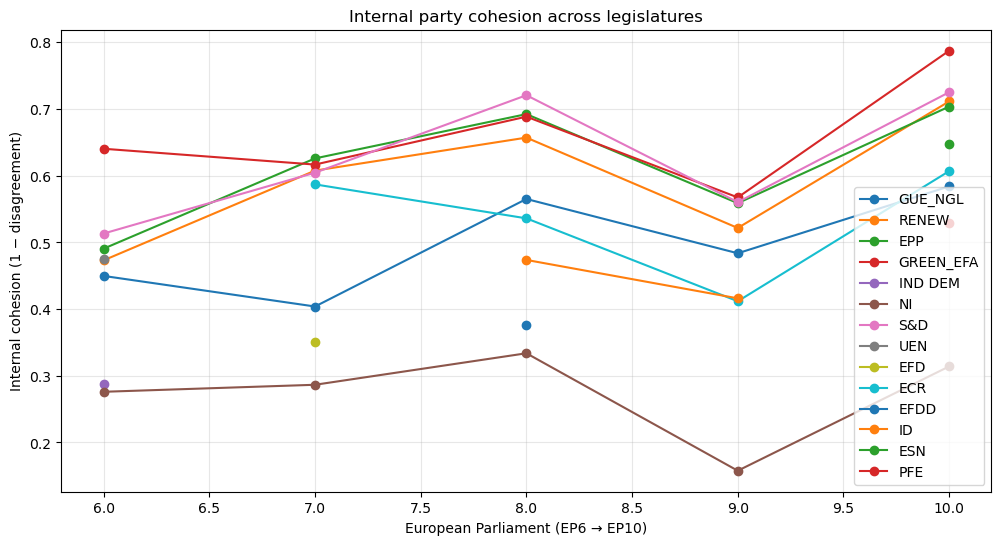

In [30]:
import matplotlib.pyplot as plt

df["avg_internal_disagreement"] = pd.to_numeric(df["avg_internal_disagreement"], errors="coerce")
df["cohesion"] = 1 - df["avg_internal_disagreement"]

plt.figure(figsize=(12,6))

for party in df["party_clean"].unique():
    sub = df[df["party_clean"] == party]
    plt.plot(sub["EP_num"], sub["cohesion"], marker="o", label=party)

plt.ylabel("Internal cohesion (1 − disagreement)")
plt.xlabel("European Parliament (EP6 → EP10)")
plt.title("Internal party cohesion across legislatures")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

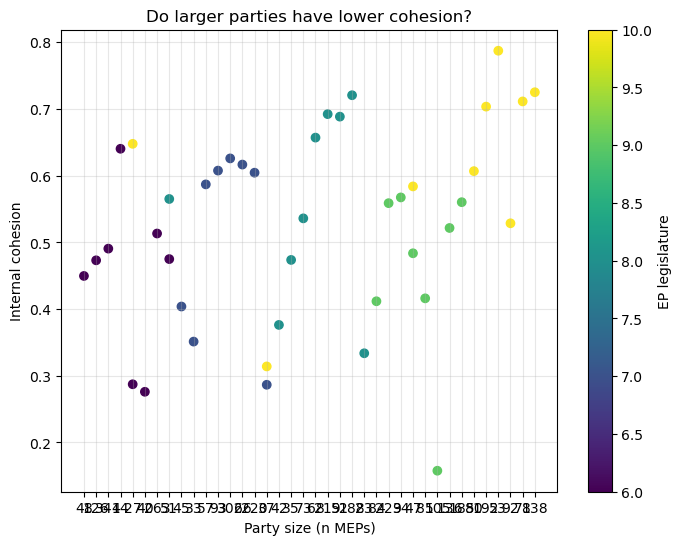

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(df["n_meps"], df["cohesion"], c=df["EP_num"], cmap="viridis")

plt.xlabel("Party size (n MEPs)")
plt.ylabel("Internal cohesion")
# do not show yaxis numbers
plt.title("Do larger parties have lower cohesion?")
plt.colorbar(label="EP legislature")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Driver: iterate over both datasets

# DATASETS = [
#     ("2021_to_2024_pre_election", "data/2021_to_2024_pre_election/all_votes.csv"),
#     ("post_2024_06_09", "data/post_2024_06_09/all_votes.csv"),
# ]

# DATASETS = [
#     ("EP6", "data/all_votes_EP6.csv"),
#     ("EP7", "data/all_votes_EP7.csv"),
#     ("EP8", "data/all_votes_EP8.csv"),
#     ("EP9", "data/all_votes_EP9.csv"),
#     ("EP10", "data/all_votes_EP10.csv"),
# ]

DATASETS = [
    ("EP6_main", "data/all_votes_main_EP6.csv"),
    ("EP7_main", "data/all_votes_main_EP7.csv"),
    ("EP8_main", "data/all_votes_main_EP8.csv"),
    ("EP9_main", "data/all_votes_main_EP9.csv"),
    ("EP10_main", "data/all_votes_main_EP10.csv"),
]

for ds_name, ds_path in DATASETS:
    print(f"\n=== Dataset: {ds_name} ===")
    df_final_ds = build_dummy_dataframe(ds_path)

    # MEP network
    print("Building MEP network...")
    G_mep_ds, mep_votes_ds, mep_meta_ds = create_mep_similarity_network(df_final_ds, similarity_threshold=0.5)
    analyze_mep_network(G_mep_ds)
    #visualize_mep_network(G_mep_ds, layout='spring', figsize=(14, 11))
    #sil_party, sil_cluster = silhouette_mep_votes(mep_votes_ds, mep_meta_ds)
    #print(f"Silhouette (MEPs by party, cosine distance): {sil_party:.4f}")
    #print(f"Silhouette (k-means clusters, cosine): {sil_cluster:.4f}")
    save_mep_gexf(G_mep_ds, f"{ds_name}")

    # # Party network
    # print("\nBuilding party network...")
    # G_party_ds, party_votes_ds, party_meta_ds = create_party_similarity_network(df_final_ds, similarity_threshold=0.3)
    # visualize_party_network(G_party_ds, colors, layout='spring', figsize=(12, 10))
    # save_party_gexf(G_party_ds, f"{ds_name}")

print("\nAll done.")



=== Dataset: EP6_main ===
Building MEP network...
Nodes: 941 | Edges: 194065 | Density: 0.4388
Avg degree: 412.47 | Max: 679 | Min: 0
Saved EP_MEP_EP6_main.gexf

=== Dataset: EP7_main ===
Building MEP network...
Nodes: 853 | Edges: 185836 | Density: 0.5114
Avg degree: 435.72 | Max: 660 | Min: 0
Saved EP_MEP_EP7_main.gexf

=== Dataset: EP8_main ===
Building MEP network...
Nodes: 858 | Edges: 158747 | Density: 0.4318
Avg degree: 370.04 | Max: 606 | Min: 0
Saved EP_MEP_EP8_main.gexf

=== Dataset: EP9_main ===
Building MEP network...
Nodes: 870 | Edges: 164696 | Density: 0.4357
Avg degree: 378.61 | Max: 642 | Min: 0
Saved EP_MEP_EP9_main.gexf

=== Dataset: EP10_main ===
Building MEP network...
Nodes: 734 | Edges: 138433 | Density: 0.5146
Avg degree: 377.20 | Max: 544 | Min: 0
Saved EP_MEP_EP10_main.gexf

All done.


In [7]:
# Run silhouette analysis for both datasets
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import KMeans


def build_dummy_dataframe(all_votes_path: str) -> pd.DataFrame:
    df0_local = pd.read_csv(all_votes_path, sep=',')
    vote_cols = [c for c in df0_local.columns if c.isdigit()]
    meta_cols = [
        "member.id",
        "member.first_name",
        "member.last_name",
        "member.country.code",
        "member.country.label",
        "member.group.code",
        "member.group.label",
        "member.group.short_label",
    ]
    meta_cols = [c for c in meta_cols if c in df0_local.columns]

    df_meta_local = df0_local[meta_cols].copy()
    df_nodes_local = df0_local[vote_cols].copy()

    df_dummy_local = pd.get_dummies(df_nodes_local, prefix_sep=":").astype(bool)
    df_final_local = pd.concat([df_meta_local, df_dummy_local], axis=1)
    return df_final_local


def silhouette_on_df_final(df_final_local: pd.DataFrame):
    vote_cols_local = [c for c in df_final_local.columns if ":" in c]
    X_local = df_final_local[vote_cols_local].astype(int).values
    party_labels_local = df_final_local['member.group.short_label'].astype(str).values

    D_local = pairwise_distances(X_local, metric='cosine')
    np.fill_diagonal(D_local, 0.0)

    sil_party_local = silhouette_score(D_local, party_labels_local, metric='precomputed')

    k_local = len(np.unique(party_labels_local))
    km_local = KMeans(n_clusters=k_local, n_init=10, random_state=42).fit(X_local)
    sil_cluster_local = silhouette_score(X_local, km_local.labels_, metric='cosine')

    return sil_party_local, sil_cluster_local


def run_for_dataset(name: str):
    i = int(name)
    path = f"data/all_votes_EP{i}.csv"
    print(f"\n=== Dataset: EP{i} ===")
    i = i + 1
    df_f = build_dummy_dataframe(path)
    sil_party, sil_cluster = silhouette_on_df_final(df_f)
    print(f"Silhouette (MEPs by party, cosine distance): {sil_party:.4f}")
    print(f"Silhouette (k-means clusters, cosine): {sil_cluster:.4f}")


for ds in ['6', '7', '8', '9', '10']:
    run_for_dataset(ds)



=== Dataset: EP6 ===
Silhouette (MEPs by party, cosine distance): 0.1117
Silhouette (k-means clusters, cosine): 0.1155

=== Dataset: EP7 ===


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_12276/763628695.py:9: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,

Silhouette (MEPs by party, cosine distance): 0.1829
Silhouette (k-means clusters, cosine): 0.1779

=== Dataset: EP8 ===


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_12276/763628695.py:9: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,

Silhouette (MEPs by party, cosine distance): 0.1733
Silhouette (k-means clusters, cosine): 0.1870

=== Dataset: EP9 ===


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_12276/763628695.py:9: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Silhouette (MEPs by party, cosine distance): 0.1393
Silhouette (k-means clusters, cosine): 0.1690

=== Dataset: EP10 ===
Silhouette (MEPs by party, cosine distance): 0.1520
Silhouette (k-means clusters, cosine): 0.1457


✅ Loaded 731 nodes and 220659 edges
Positive edges: 66325, Negative: 154334, Neutral: 0
🧩 Sampled 100 nodes

▶ Evaluating k=2 ...
k=2: best frustration=0.2076

▶ Evaluating k=3 ...
k=3: best frustration=0.1342

▶ Evaluating k=4 ...
k=4: best frustration=0.1095

▶ Evaluating k=5 ...
k=5: best frustration=0.0974

▶ Evaluating k=6 ...
k=6: best frustration=0.0904

▶ Evaluating k=7 ...
k=7: best frustration=0.0868

▶ Evaluating k=8 ...
k=8: best frustration=0.0840

▶ Evaluating k=9 ...
k=9: best frustration=0.0828

▶ Evaluating k=10 ...
k=10: best frustration=0.0821

▶ Evaluating k=11 ...
k=11: best frustration=0.0812

✅ Done in 205.11s


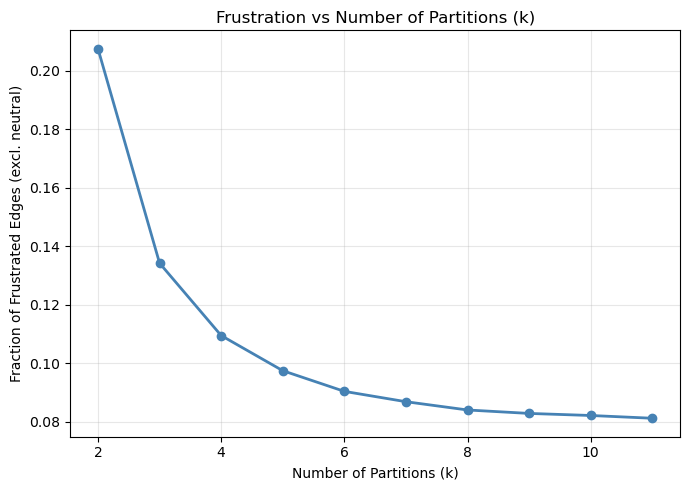


=== Clusterability Summary ===
    k  frustration
0   2     0.207596
1   3     0.134230
2   4     0.109460
3   5     0.097429
4   6     0.090351
5   7     0.086813
6   8     0.083982
7   9     0.082803
8  10     0.082095
9  11     0.081151


In [72]:
# =====================================================
# Frustration-based clusterability analysis
# with neutral edges (two-threshold encoding)
# =====================================================

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import sys

# =====================================================
# 1. Load GEXF and assign signs using two thresholds
# =====================================================
def load_signed_graph(path, sample_nodes=None, low_threshold=0.4, high_threshold=0.6):
    """
    Load GEXF graph and assign edge signs:
      +1 → strong agreement (w >= high_threshold)
       0 → neutral (low_threshold < w < high_threshold)
      -1 → strong disagreement (w <= low_threshold)
    """
    G = nx.read_gexf(path)
    print(f"✅ Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0.5))
        if w >= high_threshold:
            d["sign"] = 1
        elif w <= low_threshold:
            d["sign"] = -1
        else:
            d["sign"] = 0  # neutral edge, neither friendly nor hostile

    # Summary
    pos = sum(d["sign"] == 1 for _, _, d in G.edges(data=True))
    neg = sum(d["sign"] == -1 for _, _, d in G.edges(data=True))
    neu = sum(d["sign"] == 0 for _, _, d in G.edges(data=True))
    print(f"Positive edges: {pos}, Negative: {neg}, Neutral: {neu}")

    # Optional subgraph sampling
    if sample_nodes is not None and sample_nodes < G.number_of_nodes():
        sample = random.sample(list(G.nodes()), sample_nodes)
        G = G.subgraph(sample).copy()
        print(f"🧩 Sampled {len(G.nodes())} nodes")

    return G


# =====================================================
# 2. Frustration computation
# =====================================================
def compute_frustration(G, partition):
    """Compute fraction of frustrated edges given a partition."""
    node_idx = {n: i for i, n in enumerate(G.nodes())}
    part_arr = np.array([partition[n] for n in G.nodes()])

    edges = np.array([
        (node_idx[u], node_idx[v], d["sign"])
        for u, v, d in G.edges(data=True)
    ])

    same_cluster = part_arr[edges[:, 0]] == part_arr[edges[:, 1]]
    sign = edges[:, 2]

    # Positive edges frustrated if separated; negative if together; neutral ignored
    frustrated = ((sign == 1) & (~same_cluster)) | ((sign == -1) & (same_cluster))
    active_edges = sign != 0  # count only non-neutral edges
    if active_edges.sum() == 0:
        return np.nan
    return frustrated[active_edges].mean()


# =====================================================
# 3. Greedy local search partitioning
# =====================================================
def greedy_partition(G, k=3, max_iter=5):
    nodes = list(G.nodes())
    partition = {n: np.random.randint(0, k) for n in nodes}
    best_f = compute_frustration(G, partition)

    for iteration in range(max_iter):
        improved = False
        for node in nodes:
            current_cluster = partition[node]
            best_local = best_f
            best_cluster = current_cluster
            for c in range(k):
                if c == current_cluster:
                    continue
                partition[node] = c
                f_new = compute_frustration(G, partition)
                if f_new < best_local:
                    best_local = f_new
                    best_cluster = c
            partition[node] = best_cluster
            if best_cluster != current_cluster:
                best_f = best_local
                improved = True
        if not improved:
            break
    return partition, best_f


# =====================================================
# 4. Clusterability curve (frustration vs k)
# =====================================================
def clusterability_curve(G, k_values=range(2, 11), restarts=3):
    results = []
    start = time.time()
    for k in k_values:
        best_f = 1.0

        print(f"\n▶ Evaluating k={k} ...")
        for _ in range(restarts):
            _, f = greedy_partition(G, k=k, max_iter=5)
            if f < best_f:
                best_f = f
        results.append((k, best_f))
        print(f"k={k}: best frustration={best_f:.4f}")
    print(f"\n✅ Done in {time.time()-start:.2f}s")
    return pd.DataFrame(results, columns=["k", "frustration"])


# =====================================================
# 5. Visualization
# =====================================================
def plot_clusterability(df):
    plt.figure(figsize=(7, 5))
    plt.plot(df["k"], df["frustration"], marker="o", color="steelblue", lw=2)
    plt.title("Frustration vs Number of Partitions (k)")
    plt.xlabel("Number of Partitions (k)")
    plt.ylabel("Fraction of Frustrated Edges (excl. neutral)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =====================================================
# 6. Run the experiment
# =====================================================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    # Load GEXF with two thresholds
    G = load_signed_graph("EP_MEP_post_2024_06_09.gexf", sample_nodes=100,
                          low_threshold=0.7, high_threshold=0.7)

    # Compute frustration curve
    df_results = clusterability_curve(G, k_values=range(2, 12), restarts=5)
    plot_clusterability(df_results)

    print("\n=== Clusterability Summary ===")
    print(df_results)

🔍 Best k = 11
✅ Frustration for best partition: 0.0819

=== 🧩 Party Composition per Cluster ===
cluster                   0   1   2   3   4   5   6   7   8   9   10
member.group.short_label                                            
ECR                        0   9   1   0   0   0   0   0   0   1   0
EPP                        0   0   1   0   0   0   1   1  20   0   1
ESN                        0   0   0   0   0   0   3   0   0   0   0
GUE/NGL                    0   0   0   0   2   3   0   0   0   0   0
Greens/EFA                 0   0   0   0   0   0   0   0   5   0   3
Non-attached               0   0   0   0   1   0   0   0   0   1   0
Patriots for Europe        5   0   1   1   0   0   0   2   1   0   1
Renew                      0   0   1   1   0   0   0   0  12   0   0
S&D                        2   0   0   0   0   0   1   0  18   0   1

MEPs per cluster:
cluster
0      7
1      9
2      4
3      2
4      3
5      3
6      5
7      3
8     56
9      2
10     6
Name: count, dtype:

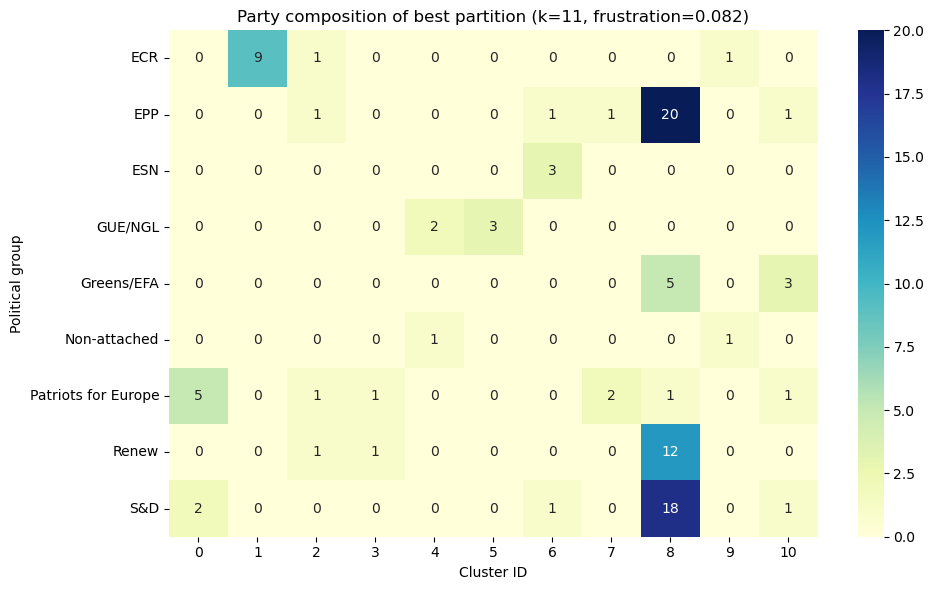

📄 Saved detailed mapping to best_partition_k11.csv


In [73]:
# =====================================================
# 7. Analyze composition of the best partition
# =====================================================

# 1️⃣  Find the best number of clusters
best_k = int(df_results.loc[df_results['frustration'].idxmin(), 'k'])
print(f"🔍 Best k = {best_k}")

# 2️⃣  Re-run the clustering to get the partition for that k
best_partition, best_f = greedy_partition(G, k=best_k, max_iter=10)
print(f"✅ Frustration for best partition: {best_f:.4f}")

# 3️⃣  Load MEP metadata (same file you used to build the GEXF)
meta_path = "data/post_2024_06_09/all_votes.csv"
meta_df = pd.read_csv(meta_path, usecols=[
    "member.id", "member.first_name", "member.last_name",
    "member.group.short_label", "member.country.code"
])
meta_df["member.id"] = meta_df["member.id"].astype(str)

# 4️⃣  Build a dataframe of node → cluster
partition_df = pd.DataFrame({
    "member.id": list(best_partition.keys()),
    "cluster": list(best_partition.values())
})

# 5️⃣  Merge with metadata
merged = partition_df.merge(meta_df, on="member.id", how="left")

# 6️⃣  Count how many MEPs from each party fall in each cluster
composition = (
    merged.groupby(["member.group.short_label", "cluster"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("\n=== 🧩 Party Composition per Cluster ===")
print(composition)
print("\nMEPs per cluster:")
print(merged["cluster"].value_counts().sort_index())

# 7️⃣  Plot a heatmap of party composition
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(composition, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Party composition of best partition (k={best_k}, frustration={best_f:.3f})")
plt.xlabel("Cluster ID")
plt.ylabel("Political group")
plt.tight_layout()
plt.show()

# 8️⃣  Optionally export details
merged.to_csv(f"best_partition_k{best_k}.csv", index=False)
print(f"📄 Saved detailed mapping to best_partition_k{best_k}.csv")

✅ Loaded 779 nodes and 246662 edges
Positive edges: 71597, Negative: 175065, Neutral: 0
🧩 Sampled 100 nodes

▶ Evaluating k=2 ...
k=2: best frustration=0.2050

▶ Evaluating k=3 ...
k=3: best frustration=0.1343

▶ Evaluating k=4 ...
k=4: best frustration=0.1126

▶ Evaluating k=5 ...
k=5: best frustration=0.1021

▶ Evaluating k=6 ...
k=6: best frustration=0.0965

▶ Evaluating k=7 ...
k=7: best frustration=0.0921

▶ Evaluating k=8 ...
k=8: best frustration=0.0899

▶ Evaluating k=9 ...
k=9: best frustration=0.0877

▶ Evaluating k=10 ...
k=10: best frustration=0.0868

▶ Evaluating k=11 ...
k=11: best frustration=0.0846

✅ Done in 193.76s


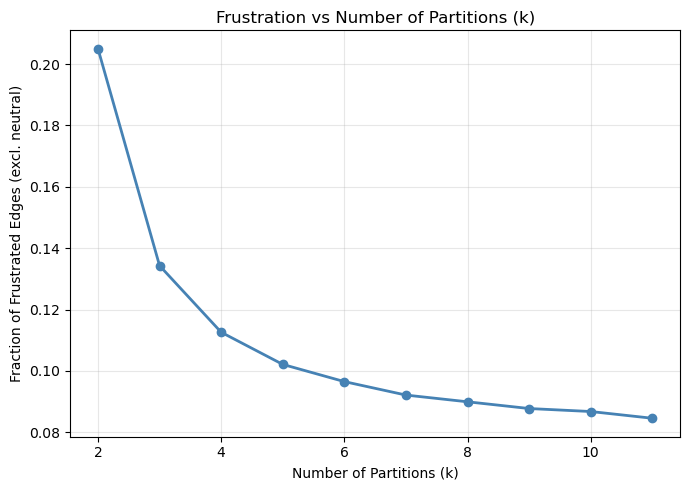


=== Clusterability Summary ===
    k  frustration
0   2     0.204972
1   3     0.134292
2   4     0.112601
3   5     0.102120
4   6     0.096515
5   7     0.092128
6   8     0.089934
7   9     0.087741
8  10     0.086766
9  11     0.084572


In [106]:
# =====================================================
# Frustration-based clusterability analysis
# with neutral edges (two-threshold encoding)
# =====================================================

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import sys

# =====================================================
# 1. Load GEXF and assign signs using two thresholds
# =====================================================
def load_signed_graph(path, sample_nodes=None, low_threshold=0.4, high_threshold=0.6):
    """
    Load GEXF graph and assign edge signs:
      +1 → strong agreement (w >= high_threshold)
       0 → neutral (low_threshold < w < high_threshold)
      -1 → strong disagreement (w <= low_threshold)
    """
    G = nx.read_gexf(path)
    print(f"✅ Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0.5))
        if w >= high_threshold:
            d["sign"] = 1
        elif w <= low_threshold:
            d["sign"] = -1
        else:
            d["sign"] = 0  # neutral edge, neither friendly nor hostile

    # Summary
    pos = sum(d["sign"] == 1 for _, _, d in G.edges(data=True))
    neg = sum(d["sign"] == -1 for _, _, d in G.edges(data=True))
    neu = sum(d["sign"] == 0 for _, _, d in G.edges(data=True))
    print(f"Positive edges: {pos}, Negative: {neg}, Neutral: {neu}")

    # Optional subgraph sampling
    if sample_nodes is not None and sample_nodes < G.number_of_nodes():
        sample = random.sample(list(G.nodes()), sample_nodes)
        G = G.subgraph(sample).copy()
        print(f"🧩 Sampled {len(G.nodes())} nodes")

    return G


# =====================================================
# 2. Frustration computation
# =====================================================
def compute_frustration(G, partition):
    """Compute fraction of frustrated edges given a partition."""
    node_idx = {n: i for i, n in enumerate(G.nodes())}
    part_arr = np.array([partition[n] for n in G.nodes()])

    edges = np.array([
        (node_idx[u], node_idx[v], d["sign"])
        for u, v, d in G.edges(data=True)
    ])

    same_cluster = part_arr[edges[:, 0]] == part_arr[edges[:, 1]]
    sign = edges[:, 2]

    # Positive edges frustrated if separated; negative if together; neutral ignored
    frustrated = ((sign == 1) & (~same_cluster)) | ((sign == -1) & (same_cluster))
    active_edges = sign != 0  # count only non-neutral edges
    if active_edges.sum() == 0:
        return np.nan
    return frustrated[active_edges].mean()


# =====================================================
# 3. Greedy local search partitioning
# =====================================================
def greedy_partition(G, k=3, max_iter=5):
    nodes = list(G.nodes())
    partition = {n: np.random.randint(0, k) for n in nodes}
    best_f = compute_frustration(G, partition)

    for iteration in range(max_iter):
        improved = False
        for node in nodes:
            current_cluster = partition[node]
            best_local = best_f
            best_cluster = current_cluster
            for c in range(k):
                if c == current_cluster:
                    continue
                partition[node] = c
                f_new = compute_frustration(G, partition)
                if f_new < best_local:
                    best_local = f_new
                    best_cluster = c
            partition[node] = best_cluster
            if best_cluster != current_cluster:
                best_f = best_local
                improved = True
        if not improved:
            break
    return partition, best_f


# =====================================================
# 4. Clusterability curve (frustration vs k)
# =====================================================
def clusterability_curve(G, k_values=range(2, 11), restarts=3):
    results = []
    start = time.time()
    for k in k_values:
        best_f = 1.0

        print(f"\n▶ Evaluating k={k} ...")
        for _ in range(restarts):
            _, f = greedy_partition(G, k=k, max_iter=5)
            if f < best_f:
                best_f = f
        results.append((k, best_f))
        print(f"k={k}: best frustration={best_f:.4f}")
    print(f"\n✅ Done in {time.time()-start:.2f}s")
    return pd.DataFrame(results, columns=["k", "frustration"])


# =====================================================
# 5. Visualization
# =====================================================
def plot_clusterability(df):
    plt.figure(figsize=(7, 5))
    plt.plot(df["k"], df["frustration"], marker="o", color="steelblue", lw=2)
    plt.title("Frustration vs Number of Partitions (k)")
    plt.xlabel("Number of Partitions (k)")
    plt.ylabel("Fraction of Frustrated Edges (excl. neutral)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =====================================================
# 6. Run the experiment
# =====================================================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    # Load GEXF with two thresholds
    G = load_signed_graph("EP_MEP_2021_to_2024_pre_election.gexf", sample_nodes=100,
                          low_threshold=0.7, high_threshold=0.7)

    # Compute frustration curve
    df_results = clusterability_curve(G, k_values=range(2, 12), restarts=5)
    plot_clusterability(df_results)

    print("\n=== Clusterability Summary ===")
    print(df_results)

🔍 Best k = 11


✅ Frustration for best partition: 0.0851

=== 🧩 Party Composition per Cluster ===
cluster                   0   1   2   3   4   5   6   7   8   9   10
member.group.short_label                                            
ECR                        1   0   1   3   0   1   0   0   0   0   0
EPP                        0   0   0   0   2   2   3   1   0   0  16
GUE/NGL                    1   0   1   1   1   0   0   0   1   0   0
Greens/EFA                 1   0   0   0   0   0   0   1   0   0   9
ID                         0   2   0   0   1   0   2   1   1   0   0
Non-attached               1   0   1   0   0   1   0   1   0   2   3
Renew                      0   4   1   0   0   0   0   1   0   0  10
S&D                        0   2   1   0   1   0   1   0   1   2  14

MEPs per cluster:
cluster
0      4
1      8
2      5
3      4
4      5
5      4
6      6
7      5
8      3
9      4
10    52
Name: count, dtype: int64


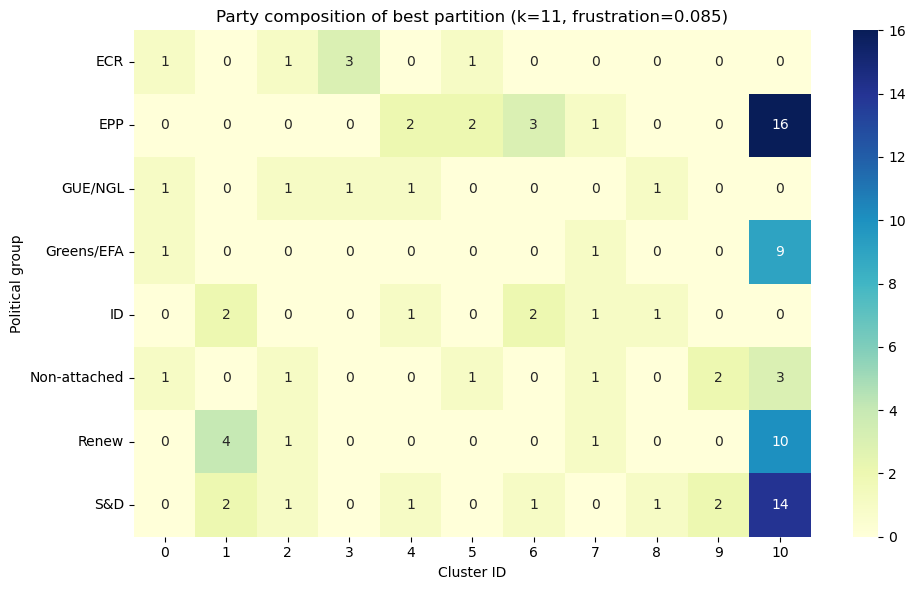

In [107]:
# =====================================================
# 7. Analyze composition of the best partition
# =====================================================

# 1️⃣  Find the best number of clusters
best_k = int(df_results.loc[df_results['frustration'].idxmin(), 'k'])
print(f"🔍 Best k = {best_k}")

# 2️⃣  Re-run the clustering to get the partition for that k
best_partition, best_f = greedy_partition(G, k=best_k, max_iter=10)
print(f"✅ Frustration for best partition: {best_f:.4f}")

# 3️⃣  Load MEP metadata (same file you used to build the GEXF)
meta_path = "data/2021_to_2024_pre_election/all_votes.csv"
meta_df = pd.read_csv(meta_path, usecols=[
    "member.id", "member.first_name", "member.last_name",
    "member.group.short_label", "member.country.code"
])
meta_df["member.id"] = meta_df["member.id"].astype(str)

# 4️⃣  Build a dataframe of node → cluster
partition_df = pd.DataFrame({
    "member.id": list(best_partition.keys()),
    "cluster": list(best_partition.values())
})

# 5️⃣  Merge with metadata
merged = partition_df.merge(meta_df, on="member.id", how="left")

# 6️⃣  Count how many MEPs from each party fall in each cluster
composition = (
    merged.groupby(["member.group.short_label", "cluster"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("\n=== 🧩 Party Composition per Cluster ===")
print(composition)
print("\nMEPs per cluster:")
print(merged["cluster"].value_counts().sort_index())

# 7️⃣  Plot a heatmap of party composition
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(composition, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Party composition of best partition (k={best_k}, frustration={best_f:.3f})")
plt.xlabel("Cluster ID")
plt.ylabel("Political group")
plt.tight_layout()
plt.show()

# 8️⃣  Optionally export details
#merged.to_csv(f"best_partition_k{best_k}.csv", index=False)
#print(f"📄 Saved detailed mapping to best_partition_k{best_k}.csv")

✅ Loaded 779 nodes and 246662 edges
Positive edges: 71597, Negative: 175065, Neutral: 0
🧩 Sampled 50 nodes

▶ Evaluating k=2 ...
k=2: best frustration=0.1648, number of frustrated edges=189

▶ Evaluating k=3 ...
k=3: best frustration=0.1064, number of frustrated edges=122

▶ Evaluating k=4 ...
k=4: best frustration=0.0898, number of frustrated edges=103

▶ Evaluating k=5 ...
k=5: best frustration=0.0820, number of frustrated edges=94

▶ Evaluating k=6 ...
k=6: best frustration=0.0776, number of frustrated edges=89

▶ Evaluating k=7 ...
k=7: best frustration=0.0750, number of frustrated edges=85

▶ Evaluating k=8 ...
k=8: best frustration=0.0732, number of frustrated edges=84

▶ Evaluating k=9 ...
k=9: best frustration=0.0724, number of frustrated edges=83

▶ Evaluating k=10 ...
k=10: best frustration=0.0715, number of frustrated edges=82

▶ Evaluating k=11 ...
k=11: best frustration=0.0706, number of frustrated edges=81

✅ Done in 81.28s


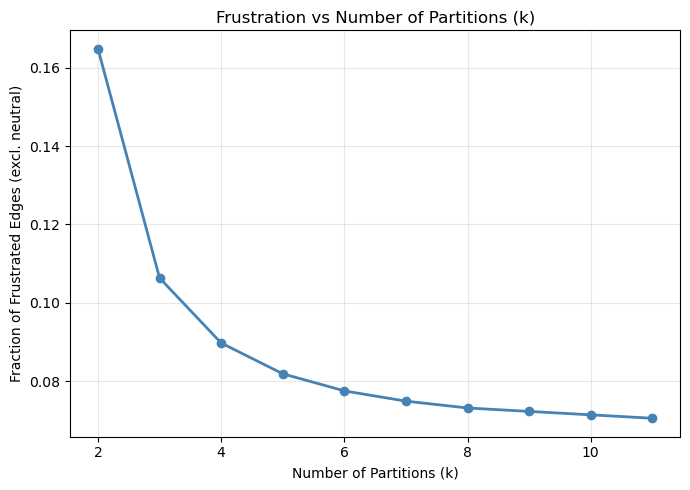


=== Clusterability Summary ===
    k  frustration
0   2     0.164778
1   3     0.106364
2   4     0.089799
3   5     0.081953
4   6     0.077594
5   7     0.074978
6   8     0.073235
7   9     0.072363
8  10     0.071491
9  11     0.070619


In [102]:
# =====================================================
# Frustration-based clusterability analysis
# with neutral edges (two-threshold encoding)
# =====================================================

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import sys

# =====================================================
# 1. Load GEXF and assign signs using two thresholds
# =====================================================
def load_signed_graph(path, sample_nodes=None, low_threshold=0.4, high_threshold=0.6):
    """
    Load GEXF graph and assign edge signs:
      +1 → strong agreement (w >= high_threshold)
       0 → neutral (low_threshold < w < high_threshold)
      -1 → strong disagreement (w <= low_threshold)
    """
    G = nx.read_gexf(path)
    print(f"✅ Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0.5))
        if w >= high_threshold:
            d["sign"] = 1
        elif w <= low_threshold:
            d["sign"] = -1
        else:
            d["sign"] = 0  # neutral edge, neither friendly nor hostile

    # Summary
    pos = sum(d["sign"] == 1 for _, _, d in G.edges(data=True))
    neg = sum(d["sign"] == -1 for _, _, d in G.edges(data=True))
    neu = sum(d["sign"] == 0 for _, _, d in G.edges(data=True))
    print(f"Positive edges: {pos}, Negative: {neg}, Neutral: {neu}")

    # Optional subgraph sampling
    if sample_nodes is not None and sample_nodes < G.number_of_nodes():
        sample = random.sample(list(G.nodes()), sample_nodes)
        G = G.subgraph(sample).copy()
        print(f"🧩 Sampled {len(G.nodes())} nodes")
        # how many edges now
        print(f"🔍 Number of edges: {G.number_of_edges()}")

    return G


# =====================================================
# 2. Frustration computation
# =====================================================
def compute_frustration(G, partition):
    """Compute fraction of frustrated edges given a partition."""
    node_idx = {n: i for i, n in enumerate(G.nodes())}
    part_arr = np.array([partition[n] for n in G.nodes()])

    edges = np.array([
        (node_idx[u], node_idx[v], d["sign"])
        for u, v, d in G.edges(data=True)
    ])

    same_cluster = part_arr[edges[:, 0]] == part_arr[edges[:, 1]]
    sign = edges[:, 2]

    # Positive edges frustrated if separated; negative if together; neutral ignored
    frustrated = ((sign == 1) & (~same_cluster)) | ((sign == -1) & (same_cluster))
    active_edges = sign != 0  # count only non-neutral edges
    if active_edges.sum() == 0:
        return np.nan
    return frustrated[active_edges].mean()


# =====================================================
# 3. Greedy local search partitioning
# =====================================================
def greedy_partition(G, k=3, max_iter=5):
    nodes = list(G.nodes())
    partition = {n: np.random.randint(0, k) for n in nodes}
    best_f = compute_frustration(G, partition)

    for iteration in range(max_iter):
        improved = False
        for node in nodes:
            current_cluster = partition[node]
            best_local = best_f
            best_cluster = current_cluster
            for c in range(k):
                if c == current_cluster:
                    continue
                partition[node] = c
                f_new = compute_frustration(G, partition)
                if f_new < best_local:
                    best_local = f_new
                    best_cluster = c
            partition[node] = best_cluster
            if best_cluster != current_cluster:
                best_f = best_local
                improved = True
        if not improved:
            break
    return partition, best_f


# =====================================================
# 4. Clusterability curve (frustration vs k)
# =====================================================
def clusterability_curve(G, k_values=range(2, 11), restarts=3):
    results = []
    start = time.time()
    for k in k_values:
        best_f = 1.0

        print(f"\n▶ Evaluating k={k} ...")
        for _ in range(restarts):
            _, f = greedy_partition(G, k=k, max_iter=5)
            if f < best_f:
                best_f = f
        results.append((k, best_f))
        print(f"k={k}: best frustration={best_f:.4f}, number of frustrated edges={int(best_f * G.number_of_edges())}")
    print(f"\n✅ Done in {time.time()-start:.2f}s")
    return pd.DataFrame(results, columns=["k", "frustration"])


# =====================================================
# 5. Visualization
# =====================================================
def plot_clusterability(df):
    plt.figure(figsize=(7, 5))
    plt.plot(df["k"], df["frustration"], marker="o", color="steelblue", lw=2)
    plt.title("Frustration vs Number of Partitions (k)")
    plt.xlabel("Number of Partitions (k)")
    plt.ylabel("Fraction of Frustrated Edges (excl. neutral)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =====================================================
# 6. Run the experiment
# =====================================================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    # Load GEXF with two thresholds
    G = load_signed_graph("EP_MEP_2021_to_2024_pre_election.gexf", sample_nodes=50,
                          low_threshold=0.7, high_threshold=0.7)

    # Compute frustration curve
    df_results = clusterability_curve(G, k_values=range(2, 12), restarts=20)
    plot_clusterability(df_results)

    print("\n=== Clusterability Summary ===")
    print(df_results)

✅ Loaded 731 nodes and 220659 edges
Positive edges: 66325, Negative: 154334, Neutral: 0
🧩 Sampled 50 nodes
🔍 Number of edges: 1055

▶ Evaluating k=2 ...
k=2: best frustration=0.2066, number of frustrated edges=218

▶ Evaluating k=3 ...
k=3: best frustration=0.1232, number of frustrated edges=130

▶ Evaluating k=4 ...
k=4: best frustration=0.0967, number of frustrated edges=102

▶ Evaluating k=5 ...
k=5: best frustration=0.0844, number of frustrated edges=89

▶ Evaluating k=6 ...
k=6: best frustration=0.0768, number of frustrated edges=81

▶ Evaluating k=7 ...
k=7: best frustration=0.0730, number of frustrated edges=77

▶ Evaluating k=8 ...
k=8: best frustration=0.0701, number of frustrated edges=74

▶ Evaluating k=9 ...
k=9: best frustration=0.0682, number of frustrated edges=72

▶ Evaluating k=10 ...
k=10: best frustration=0.0673, number of frustrated edges=71

▶ Evaluating k=11 ...
k=11: best frustration=0.0664, number of frustrated edges=70

✅ Done in 80.47s


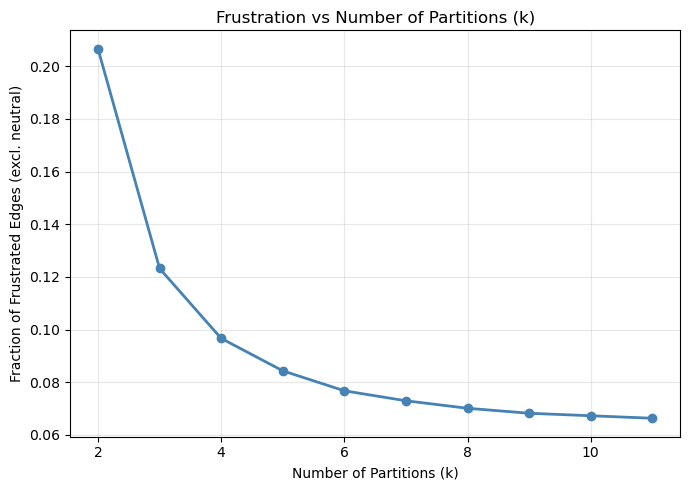


=== Clusterability Summary ===
    k  frustration
0   2     0.206635
1   3     0.123223
2   4     0.096682
3   5     0.084360
4   6     0.076777
5   7     0.072986
6   8     0.070142
7   9     0.068246
8  10     0.067299
9  11     0.066351


In [103]:
# =====================================================
# Frustration-based clusterability analysis
# with neutral edges (two-threshold encoding)
# =====================================================

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import sys

# =====================================================
# 1. Load GEXF and assign signs using two thresholds
# =====================================================
def load_signed_graph(path, sample_nodes=None, low_threshold=0.4, high_threshold=0.6):
    """
    Load GEXF graph and assign edge signs:
      +1 → strong agreement (w >= high_threshold)
       0 → neutral (low_threshold < w < high_threshold)
      -1 → strong disagreement (w <= low_threshold)
    """
    G = nx.read_gexf(path)
    print(f"✅ Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0.5))
        if w >= high_threshold:
            d["sign"] = 1
        elif w <= low_threshold:
            d["sign"] = -1
        else:
            d["sign"] = 0  # neutral edge, neither friendly nor hostile

    # Summary
    pos = sum(d["sign"] == 1 for _, _, d in G.edges(data=True))
    neg = sum(d["sign"] == -1 for _, _, d in G.edges(data=True))
    neu = sum(d["sign"] == 0 for _, _, d in G.edges(data=True))
    print(f"Positive edges: {pos}, Negative: {neg}, Neutral: {neu}")

    # Optional subgraph sampling
    if sample_nodes is not None and sample_nodes < G.number_of_nodes():
        sample = random.sample(list(G.nodes()), sample_nodes)
        G = G.subgraph(sample).copy()
        print(f"🧩 Sampled {len(G.nodes())} nodes")
        # how many edges now
        print(f"🔍 Number of edges: {G.number_of_edges()}")

    return G


# =====================================================
# 2. Frustration computation
# =====================================================
def compute_frustration(G, partition):
    """Compute fraction of frustrated edges given a partition."""
    node_idx = {n: i for i, n in enumerate(G.nodes())}
    part_arr = np.array([partition[n] for n in G.nodes()])

    edges = np.array([
        (node_idx[u], node_idx[v], d["sign"])
        for u, v, d in G.edges(data=True)
    ])

    same_cluster = part_arr[edges[:, 0]] == part_arr[edges[:, 1]]
    sign = edges[:, 2]

    # Positive edges frustrated if separated; negative if together; neutral ignored
    frustrated = ((sign == 1) & (~same_cluster)) | ((sign == -1) & (same_cluster))
    active_edges = sign != 0  # count only non-neutral edges
    if active_edges.sum() == 0:
        return np.nan
    return frustrated[active_edges].mean()


# =====================================================
# 3. Greedy local search partitioning
# =====================================================
def greedy_partition(G, k=3, max_iter=5):
    nodes = list(G.nodes())
    partition = {n: np.random.randint(0, k) for n in nodes}
    best_f = compute_frustration(G, partition)

    for iteration in range(max_iter):
        improved = False
        for node in nodes:
            current_cluster = partition[node]
            best_local = best_f
            best_cluster = current_cluster
            for c in range(k):
                if c == current_cluster:
                    continue
                partition[node] = c
                f_new = compute_frustration(G, partition)
                if f_new < best_local:
                    best_local = f_new
                    best_cluster = c
            partition[node] = best_cluster
            if best_cluster != current_cluster:
                best_f = best_local
                improved = True
        if not improved:
            break
    return partition, best_f


# =====================================================
# 4. Clusterability curve (frustration vs k)
# =====================================================
def clusterability_curve(G, k_values=range(2, 11), restarts=3):
    results = []
    start = time.time()
    for k in k_values:
        best_f = 1.0

        print(f"\n▶ Evaluating k={k} ...")
        for _ in range(restarts):
            _, f = greedy_partition(G, k=k, max_iter=5)
            if f < best_f:
                best_f = f
        results.append((k, best_f))
        print(f"k={k}: best frustration={best_f:.4f}, number of frustrated edges={int(best_f * G.number_of_edges())}")
    print(f"\n✅ Done in {time.time()-start:.2f}s")
    return pd.DataFrame(results, columns=["k", "frustration"])


# =====================================================
# 5. Visualization
# =====================================================
def plot_clusterability(df):
    plt.figure(figsize=(7, 5))
    plt.plot(df["k"], df["frustration"], marker="o", color="steelblue", lw=2)
    plt.title("Frustration vs Number of Partitions (k)")
    plt.xlabel("Number of Partitions (k)")
    plt.ylabel("Fraction of Frustrated Edges (excl. neutral)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# =====================================================
# 6. Run the experiment
# =====================================================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    # Load GEXF with two thresholds
    G = load_signed_graph("EP_MEP_post_2024_06_09.gexf", sample_nodes=50,
                          low_threshold=0.7, high_threshold=0.7)

    # Compute frustration curve
    df_results = clusterability_curve(G, k_values=range(2, 12), restarts=20)
    plot_clusterability(df_results)

    print("\n=== Clusterability Summary ===")
    print(df_results)